In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = '../../Dataset/FER2013'
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [3]:
img_width, img_height = 48, 48
data = []
labels = []

In [4]:
for category in categories:
    category_path = os.path.join(dataset_path, 'train', category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))  # Resize image
            img = img / 255.0  # Normalize pixel values
            data.append(img)
            labels.append(categories.index(category))

In [5]:
data = np.array(data)
data = np.expand_dims(data, axis=-1)  # Add channel dimension for grayscale
labels = np.array(labels)

In [6]:
labels = to_categorical(labels, num_classes=len(categories))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (22967, 48, 48, 1)
Validation data shape: (5742, 48, 48, 1)


In [9]:
from skimage.feature import local_binary_pattern

P = 8 
R = 1 

def lbp_histogram(image):
    lbp = local_binary_pattern(image, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def process_dataset_with_lbp(data):
    lbp_features = []
    for img in data:
        image = img.reshape(img_width, img_height)
        hist = lbp_histogram(image)
        lbp_features.append(hist)
    return np.array(lbp_features)

X_train_lbp = process_dataset_with_lbp(X_train)
X_val_lbp = process_dataset_with_lbp(X_val)
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_train_combined = np.concatenate((X_train_flat, X_train_lbp), axis=1)
X_val_combined = np.concatenate((X_val_flat, X_val_lbp), axis=1)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

# Define the CNN input for raw images
cnn_input = Input(shape=(48, 48, 1))  # for grayscale images of size 48x48

# Define the CNN layers
x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Define the LBP input
lbp_input = Input(shape=(X_train_lbp.shape[1],))  # assuming X_train_lbp is your LBP feature set

# Concatenate the CNN and LBP features
combined = concatenate([x, lbp_input])

# Fully connected layers after the concatenation
z = Dense(1024, activation='relu')(combined)
z = Dropout(0.5)(z)  # Dropout layer to reduce overfitting
z = Dense(7, activation='softmax')(z)  # `num_classes` should match the number of emotions you're classifying

# Create the dual-input model
model = Model(inputs=[cnn_input, lbp_input], outputs=z)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 46, 46, 32)           320       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 23, 23, 32)           0         ['conv2d_12[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 21, 21, 64)           18496     ['max_pooling2d_12[0][0]']

In [17]:
history = model.fit(
    [X_train, X_train_lbp], y_train, 
    validation_data=([X_val, X_val_lbp], y_val),
    epochs=50,
    batch_size=32
)


Epoch 1/50
718/718 [==============================] - 36s 47ms/step - loss: 1.8012 - accuracy: 0.2511 - val_loss: 1.7288 - val_accuracy: 0.2907
Epoch 2/50
718/718 [==============================] - 28s 39ms/step - loss: 1.5896 - accuracy: 0.3712 - val_loss: 1.4439 - val_accuracy: 0.4340
Epoch 3/50
718/718 [==============================] - 28s 38ms/step - loss: 1.3737 - accuracy: 0.4668 - val_loss: 1.3543 - val_accuracy: 0.4727
Epoch 4/50
718/718 [==============================] - 26s 36ms/step - loss: 1.2676 - accuracy: 0.5156 - val_loss: 1.2568 - val_accuracy: 0.5239
Epoch 5/50
718/718 [==============================] - 26s 36ms/step - loss: 1.1836 - accuracy: 0.5491 - val_loss: 1.2278 - val_accuracy: 0.5388
Epoch 6/50
718/718 [==============================] - 27s 38ms/step - loss: 1.1224 - accuracy: 0.5778 - val_loss: 1.2174 - val_accuracy: 0.5399
Epoch 7/50
718/718 [==============================] - 27s 38ms/step - loss: 1.0593 - accuracy: 0.6013 - val_loss: 1.2358 - val_accuracy:

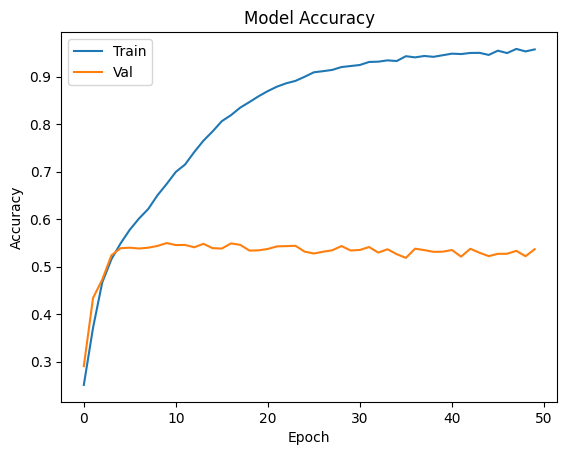

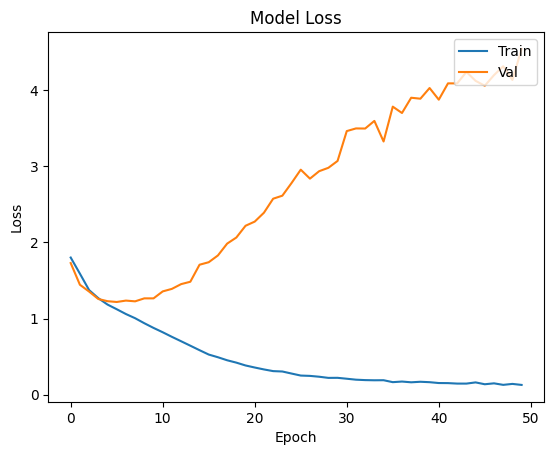

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()